In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Прогнозирование поведения клиента (ДЗ)

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate, dlq ratio и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score с семинара (**data_scores.csv**) и PD, который ты получил по итогу выполнения предыдущего ДЗ (скор, предсказывающий вероятность выпадения в дефолт за первые 12 месяцев жизни кредита). Не бойся выходить за рамки методов, предлженных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **14 баллов** (10 за обязатеьную часть и 4 за часть со звездочкой). Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматться в случае неполного выполнения задания или отсутствия аргументации.

Задание со зведочкой не обязательно к выполнению.

#### Задачи:

1) Построить кривые DEF rate и DLQ ratio, используя PD, полученный на предыдущем ДЗ. В качестве результаты приложите отдельный ноутбук с названием 'Surname_def_dlq.ipynb' (1 балл)

2) Построить кривые CLO rate 
    - Построить винтажи CLO ratio (1 балл)
    - Выбрать переменную для разбивки по бакетам (2 балла)
    - Провести анализ поколений (0.5 баллов)
    - Построить винтажи CLO rate (2 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Построить среднее по винтажам для каждого бакета (1 балл)
    - Сгладить кривые (2 балла)
    
3) * Провести анализ на наличие макроэкономического воздействия (4 балла)

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

## Кривые CLO rate

#### Выгружаем данные с винтажами и скорами

In [2]:
df = pd.read_csv('df_scores_and_vintages.csv')

In [3]:
df = df.iloc[:, 1:]

### Построй винтажи кривой Clo ratio (1 балл)


Clo ratio - доля закрытых счетов:
### $$ CLO ratio_n = \frac{\#CLO_n}{\#cnt_n}$$


In [4]:
clo_ratio_data = (df.groupby(["gen_quarter_dt", "statement_num"])   # группировка по поколению и месяцу жизни клиента
        .agg({"clo_flg":np.mean})                                     # считаем средний уровень
        .rename(columns = {"clo_flg": 'clo_ratio'})                   # переименовываем столбец со средними значениями
        .unstack('gen_quarter_dt'))                                   # разворачиваем таблицу, столбцы теперь поколения
clo_ratio_data

clo_ratio                                            
gen_quarter_dt 2019-01-01 2019-04-01 2019-07-01 2019-10-01 2020-01-01
statement_num                                                        
1                0.051788   0.050273   0.058670   0.084000   0.086524
2                0.085926   0.077191   0.091124   0.127277   0.126107
3                0.117175   0.102703   0.117151   0.161774   0.158291
4                0.145646   0.127774   0.145901   0.196712   0.185291
5                0.175844   0.156436   0.177340   0.231400   0.211534
6                0.201796   0.185696   0.210318   0.259343   0.241269
7                0.230898   0.216760   0.241421   0.284029   0.274476
8                0.261562   0.243628   0.268251   0.308284   0.305355
9                0.283881   0.270076   0.292456   0.335036   0.336543
10               0.314207   0.295948   0.311379   0.360522   0.368616
11               0.339211   0.318848   0.329223   0.387589   0.397974
12               0.360110   0.338271   0.347874   0.413832   0.425594
13               0.384431   0.352655   0.370197   0.437508   0.448362
14               0.402565   0.369488   0.390011   0.464373   0.469685
15               0.416227   0.386478   0.413159   0.488285   0.489614
16               0.430026   0.404641   0.434755   0.509771   0.509794
17               0.443925   0.423148   0.455934   0.528390   0.530132
18               0.459476   0.442625   0.476614   0.547301   0.547803
19               0.478885   0.460496   0.495403   0.564491   0.565547
20               0.497187   0.480615   0.512219   0.582588   0.582632
21               0.515689   0.498322   0.528389   0.600139   0.599234
22               0.538526   0.514448   0.544130   0.617934   0.614399
23               0.553721   0.530277   0.561009   0.633133   0.628052
24               0.567804   0.546353   0.575026   0.645755   0.641786

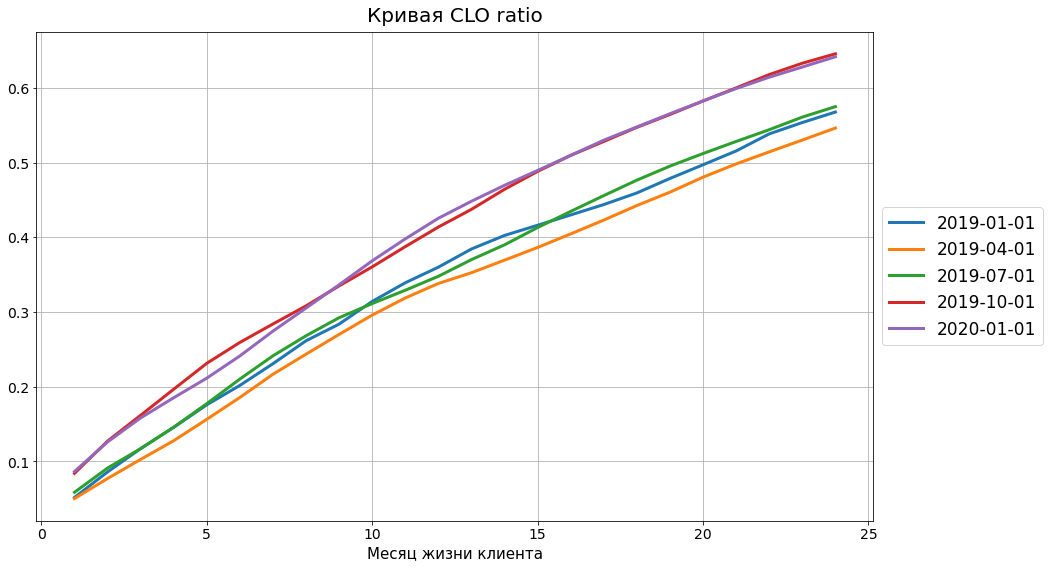

In [5]:
def plot_clo_ratio_by_generation(df):
    return (df.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack('gen_quarter_dt')
            ['clo_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_clo_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выбери переменную, которая делит кривые наилучшим образом (2 балла)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

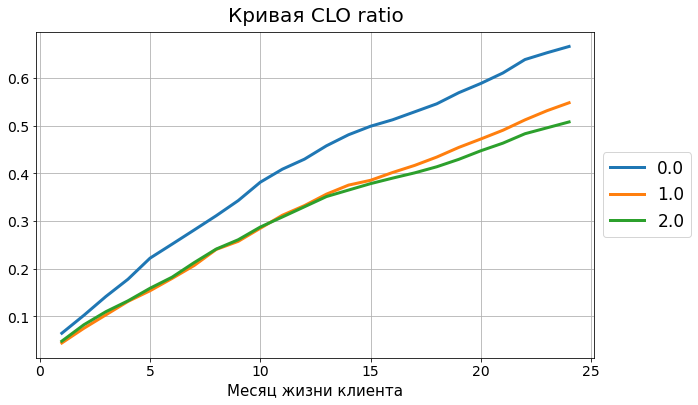

In [6]:
def plot_clo_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack(bucket)
            ['clo_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

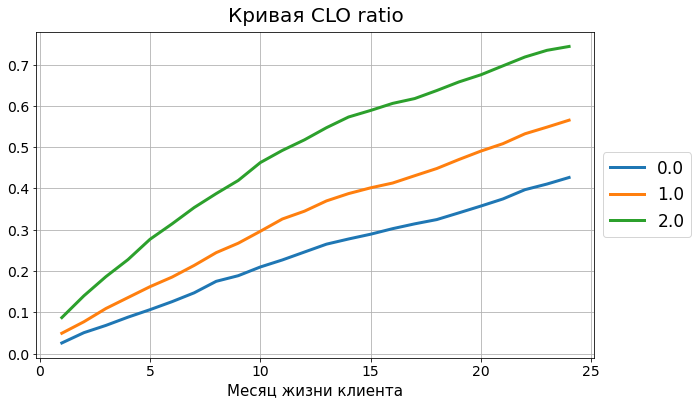

In [7]:
def plot_clo_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack(bucket)
            ['clo_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая CLO ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: выберем переменную X, так как она разделяет кривые лучше, чем PD

### Анализ странных поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

In [8]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))  

<AxesSubplot:xlabel='gen_month_dt'>

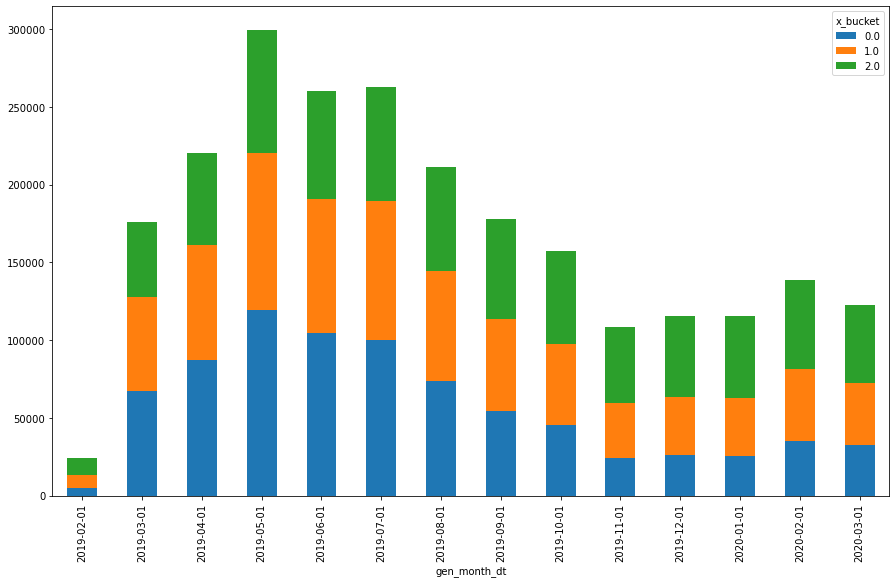

In [9]:
plot_distribution(df, 'x_bucket')

#### Вывод: данных для анализа недостаточно в феврале 2019 года, поэтому не будет рассматривать их далее.

In [10]:
# Исключаем плохое поколение
df.query(''' ~((gen_month_dt == '2019-02-01')) ''', inplace = True)

### Кривые СLO Rate в разбивке по бакетам 

$CLO_n$ - количество счетов, закрывшихся в месяц $n$

$ACT_{n-1}$ - количество активных счетов (в просрочке 0-3) в месяц $n-1$

## $$ CLO Rate_n = \frac{\#CLO_n}{\#Act_{n-1}} $$

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

In [11]:
%matplotlib inline
# Выгружаем таблицу c винтажами

clo_rate_data = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'x_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('clo_rate = clo_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_clo_rate_by_generation(x_bucket):
    
    cur_df = clo_rate_data.query('x_bucket == ' + str(x_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['clo_rate']
            .plot(ax=None, figsize=(25, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_clo_rate_by_generation, x_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='x_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_cl…

#### Выводы: с увеличением значений X_score увеличивается "скорость" досрочного закрытия вклада, так как можно заметить, что в среднем значения CLO rate у 2 бакета выше, чем у 1 (а у 1 бакета выше, чем у 0)

### Особые точки (0.5 баллов) 

#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

1) Есть особые точки, связанные с коронакризисом: у клиентов, взявших кредит в 1ом квартале 2019 года, наблюдается резкое уменьшение CLO rate на 15-18 месяц жизни, в 2ом квартале 2019 года - на 12-15 месяц жизни и так далее со смещением в 3 месяца на графике (так как эти ряды в реальном времени смещены на 3 месяца). Это связано с тем, что у клиентов могло не оказаться достаточно денег, чтобы закрыть кредит досрочно. Причем заметим, что у клиентов с большим X_score (x_bucket = 2) эти выбросы не такие явные, как у клиентов с меньшим X_score;

2) 1ый месяц жизни клиентов тоже является особой точкой. На графиках мы видим пик, наибольшее значение "скорости" закрытия кредитов клиентов. Он связан с тем, что некоторые клиенты решаются сразу погасить свой кредит в первый же месяц (досрочное погашение).

1-ую точку трогать не будет (ее можно будет отделить с помощью матричных вычислений), 2ую не будем убирать, но не будем на ней сглаживать кривые (то есть аппроксимировать кривой будем только те точки, которые идут после)

### Среднее по бакетам (1 балл)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

Удалим слишком шумные данные: у всех бакетов удалим кривую от 2019-01-01

In [12]:
exception_query = ''' ~(gen_quarter_dt == '2019-01-01') '''
clo_rate_data.query(exception_query, inplace = True)

In [13]:
# делим на бакеты
buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)

# считаем среднее
clo_rate_mean = clo_rate_data.groupby(['statement_num', 'x_bucket'])\
    .agg({'clo_rate':np.mean})\
    .rename(columns = {'clo_rate':'Среднее'})

In [14]:
def plot_clo_rate_mean(x_bucket):
    vintages_graph = clo_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['clo_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая CLO rate, pd_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_clo_rate_mean, x_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='x_bucket', options=(0.0, 1.0, 2.0), value=0.0), Output()), _dom_cl…

### Сглаживание средних кривых (2 балла)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

In [16]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

In [17]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]  # Начальные значения копируем
    
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

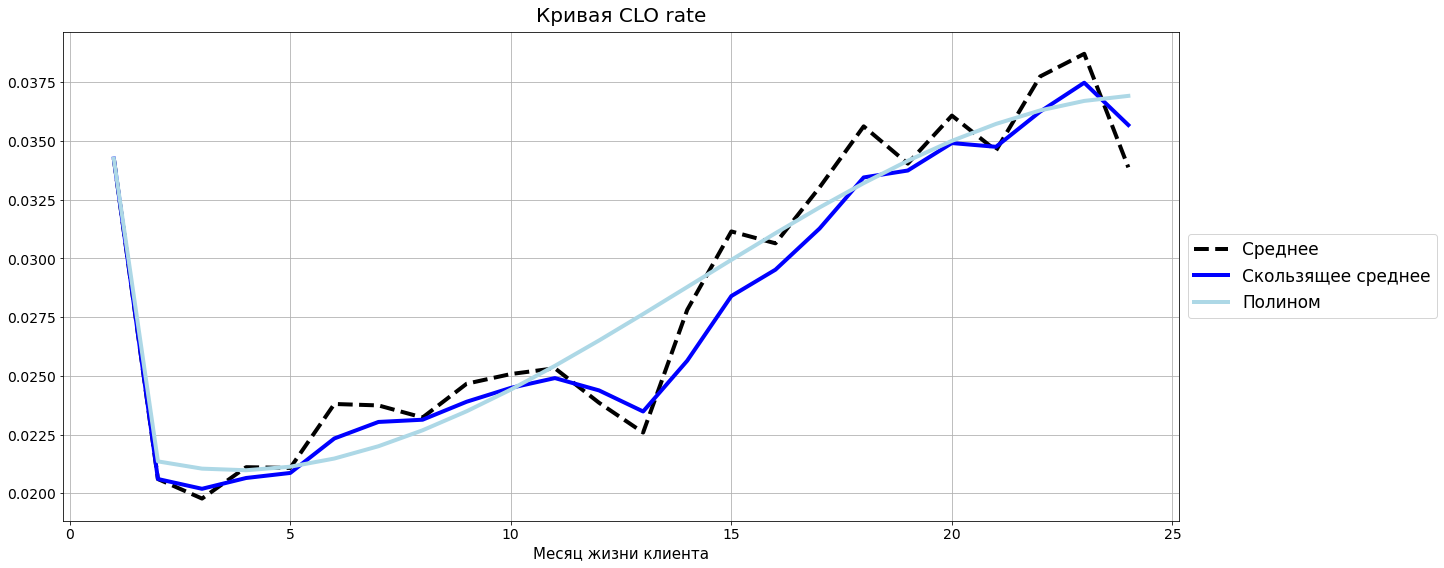

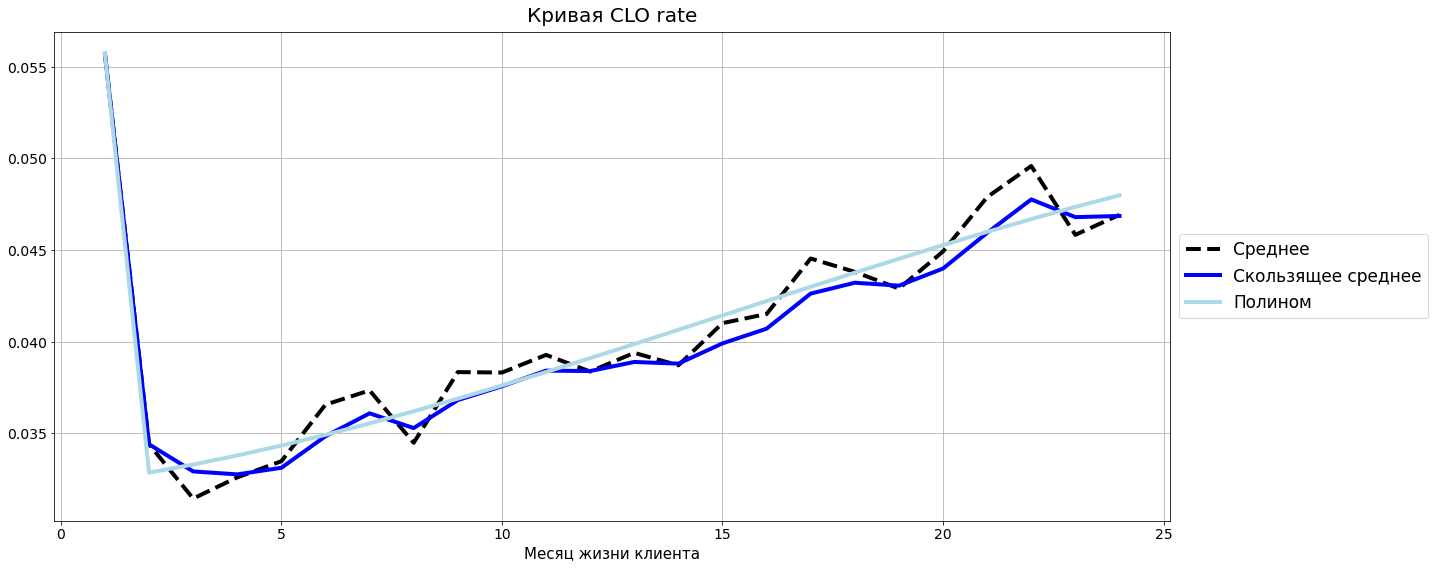

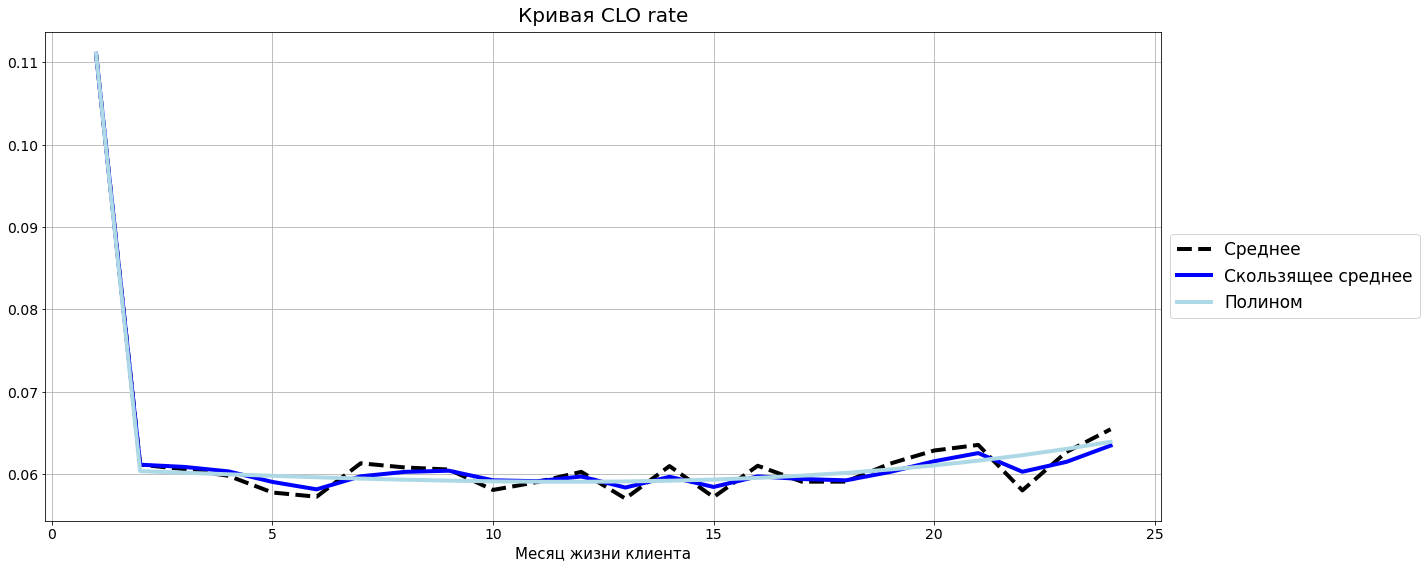

In [18]:
for i in range(3):
    df_bucket = clo_rate_mean.query(f'x_bucket == {i}').reset_index().set_index(['statement_num'])
    df_polynom = polynom_approximation(df_bucket, 2,24,3)
    df_smooth = exponential_smoothing(df_bucket, 2,24,0.5)
    # Строим получившиеся графики вместе
    plt.figure(figsize=(20, 9))
    df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
    df_smooth['Скользящее среднее'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
    df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: выберем полиномиальное сглаживание, так как оно меньше зависит от выбросов, связанных с коронавирусом (экспоненциальное сглаживание их учитывает сильно в вычислениях, чем полиномиальное). Полином берем третьей степени, чтобы сделать кривые более "гибкие".

### Сглаженные кривые по всем трем бакетам X_score

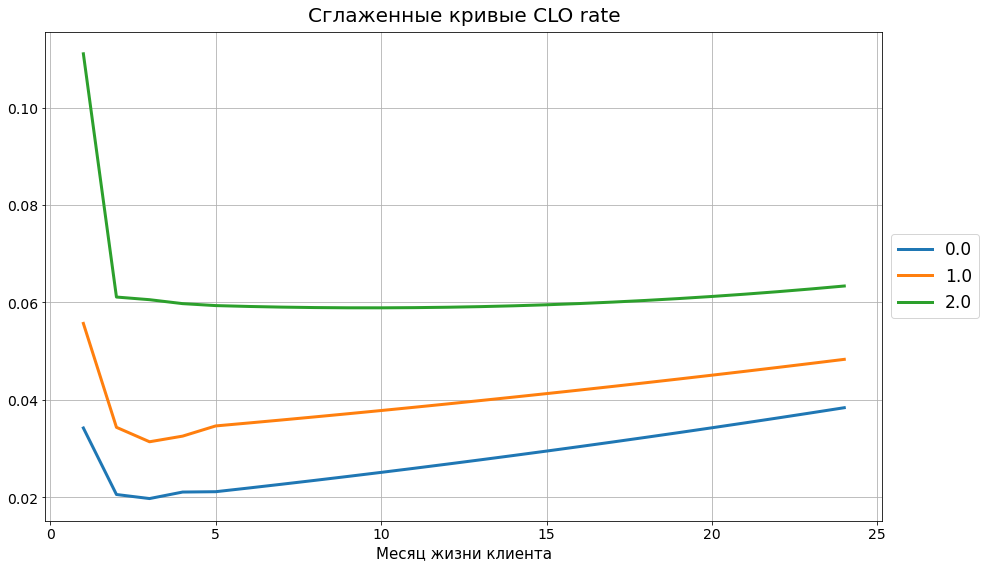

In [19]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [22]:
clo_rate_mean.unstack().to_excel('clo_rate_mean.xlsx', engine='xlsxwriter')

## (Задача со звездочкой) 
## Макроэкономические воздействие (4 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

Используем функции из семинара

In [22]:
def curve_build(data, 
                feature, 
                generation = 'generation_quart',
                statement_num = 'statement_num', 
                group_label = '1'):
    
    """Вспомогательная функция для построения разложения в рамках одного бакета
    
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов 
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])
    
    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1 

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0 
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)], 
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице. 
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean
    
    # И умножаем на полученный коэффициент кривые созревания
    
    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)
    
    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

In [23]:
# Подготавливаем данные
df_rate = df.groupby(["x_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"clo_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"clo_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
        .eval('clo_rate = clo_cnt / prev_act_cnt', inplace=False)

df_rate['gen_month_dt'] = pd.to_datetime(df_rate['gen_month_dt'])
# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых 
res = decomposition(df_rate, 
                       generation = 'gen_month_dt', 
                       group = 'x_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'clo_rate')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


x_bucket = 0.0
Initial 88.437776
0  54.831048
1  54.047973
2  52.426138
3  36.936253
4  17.700178
5  6.896667
6  4.070358
7  3.305693
8  2.968032
9  2.777494
10  2.661842
11  2.589216
12  2.542036
13  2.510073
14  2.487279
15  2.420908
16  2.418357
17  2.178330
18  2.074750
19  1.787211
20  1.667955
21  1.028288
22  1.011672
23  1.001005
24  0.951871
25  0.944740
26  0.941276
27  0.939551
28  0.938677
29  0.937751
30  0.937750
x_bucket = 1.0
Initial 251.579003
31  157.133415
32  149.125408
33  122.051206
34  36.266917
35  15.623496
36  8.845896
37  6.171926
38  4.944005
39  4.325395
40  3.991683
41  3.800580
42  3.482796
43  3.476565
44  3.309913
45  2.993945
46  2.598476
47  2.519479
48  2.469067
49  2.435887
50  2.414022
51  2.399693
52  2.390359
53  2.384311
54  2.380409
55  2.377901
56  2.376294
57  2.375266
58  2.374610
59  2.374193
60  2.373927
61  2.373758
62  2.373651
63  2.373583
64  2.373540
65  2.373512
66  2.373495
67  2.373484
68  2.373477
69  2.373473
70  2.373470
71  2.3

Рисуем график внешнего воздействия

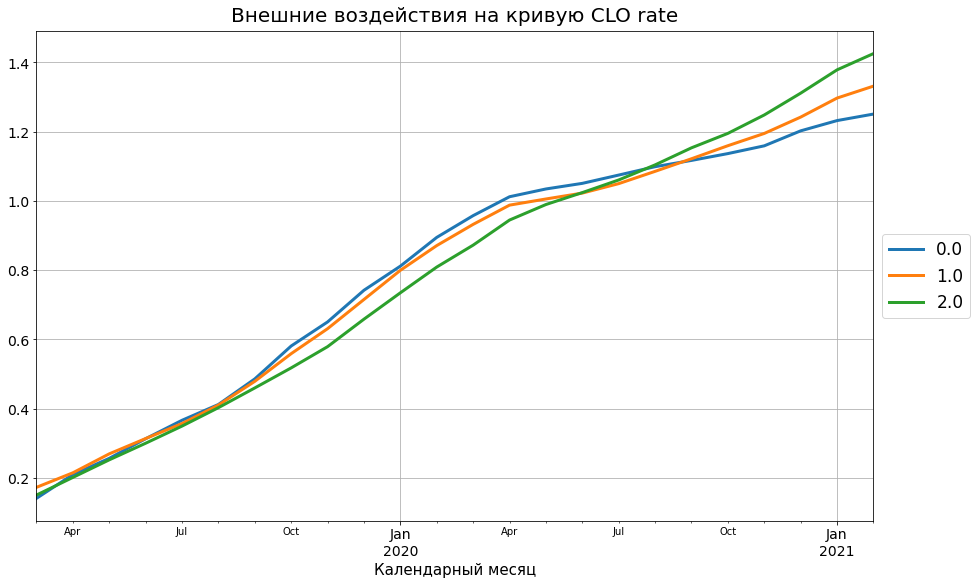

In [24]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Рисуем кривую созревания CLO rate

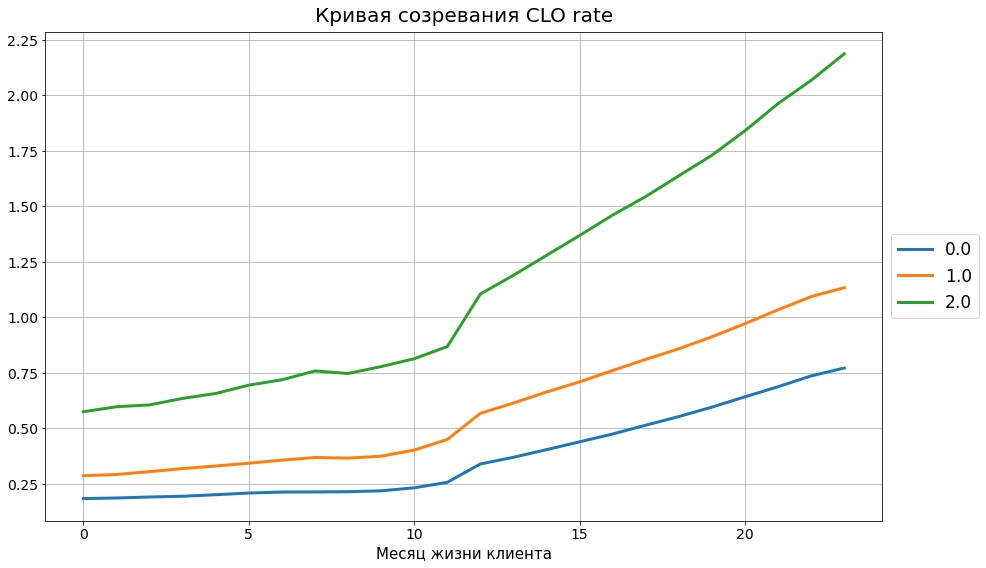

In [25]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

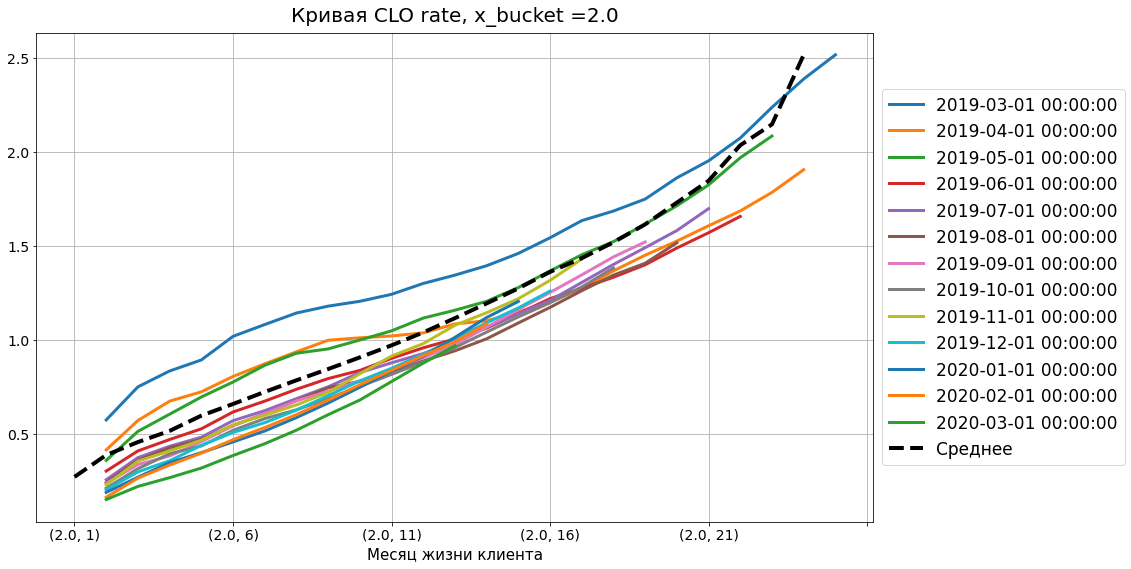

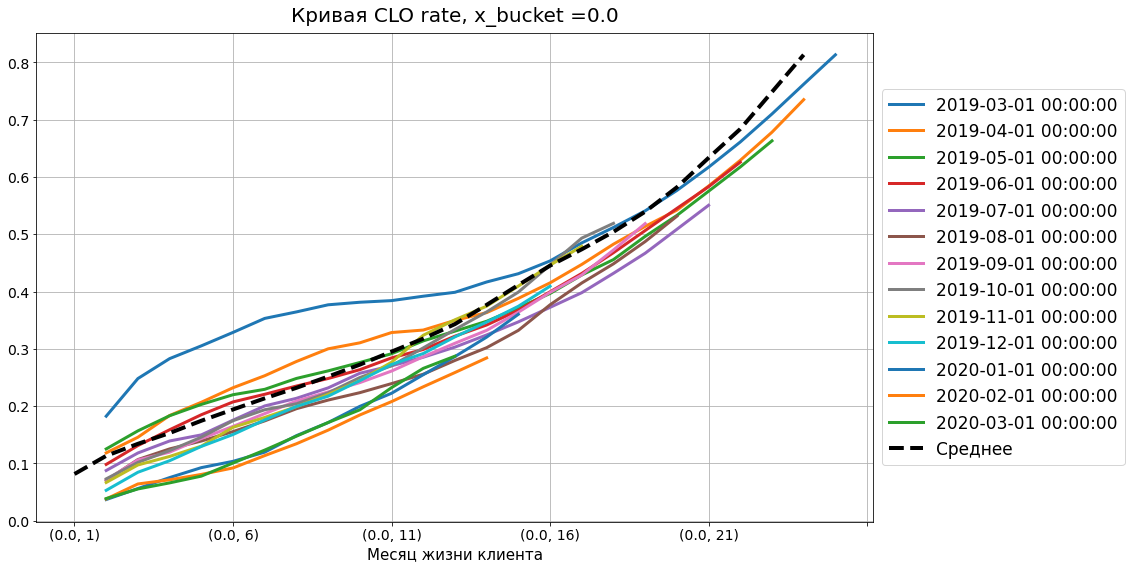

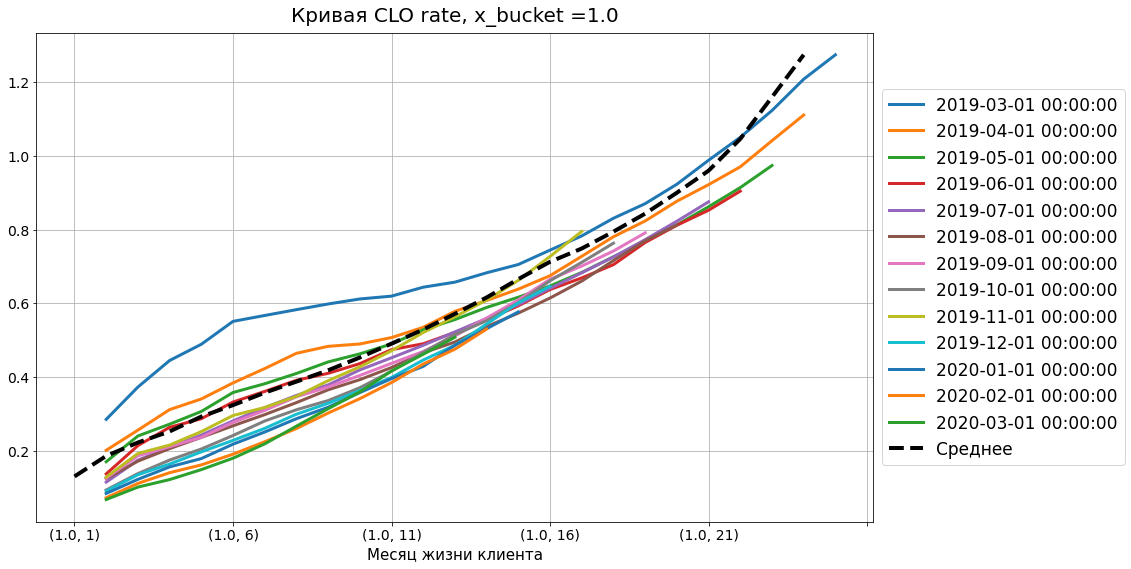

In [26]:
#Считаем среднее

clo_rate_mean = res['fitted_data'].groupby([ 'x_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(x_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая CLO rate, x_bucket =" + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_clo_rate_mean(i)

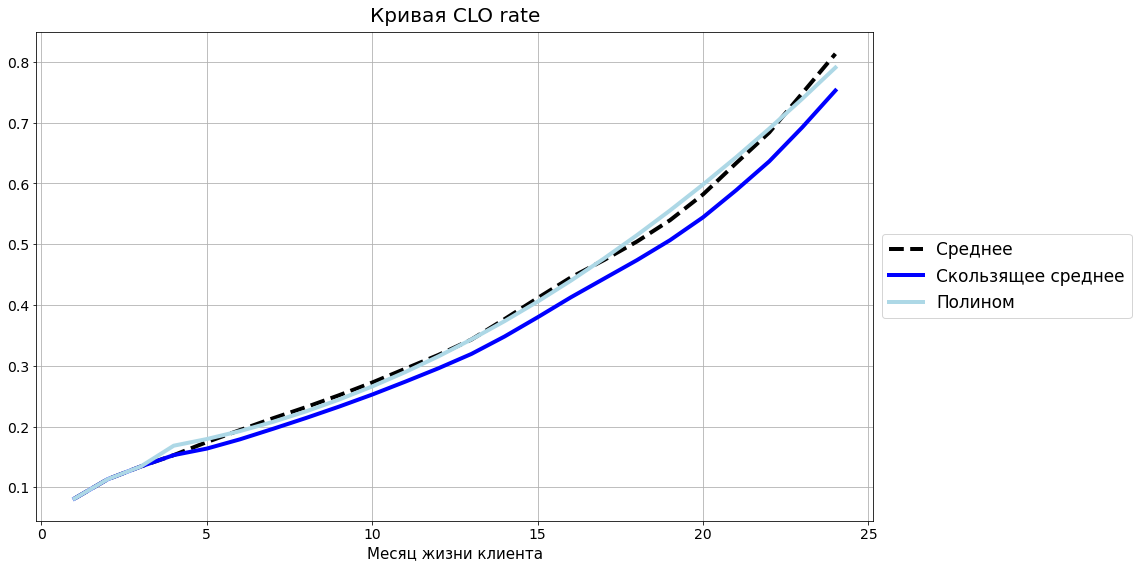

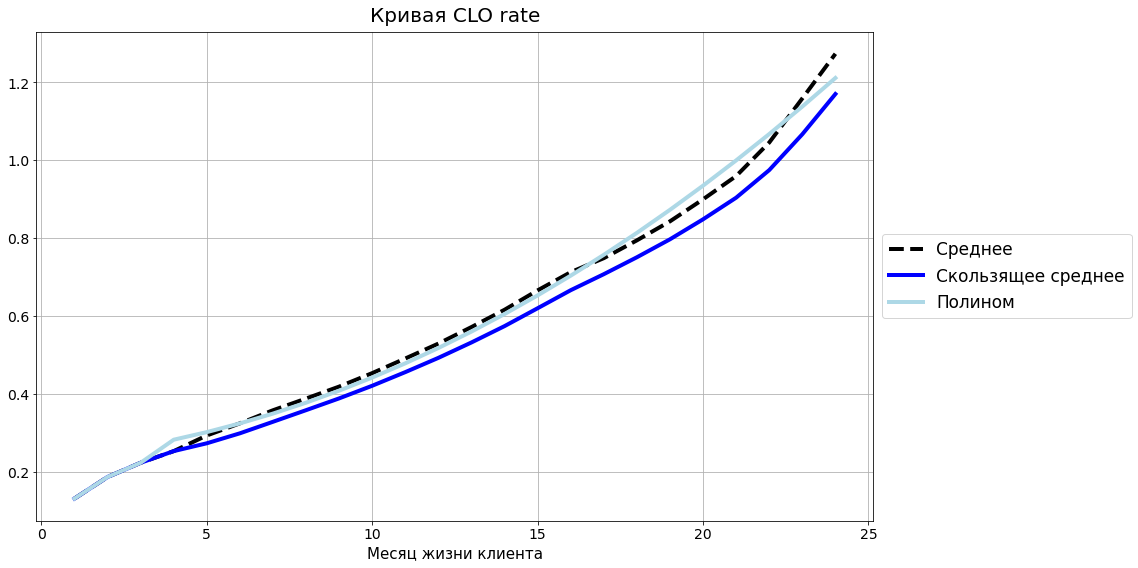

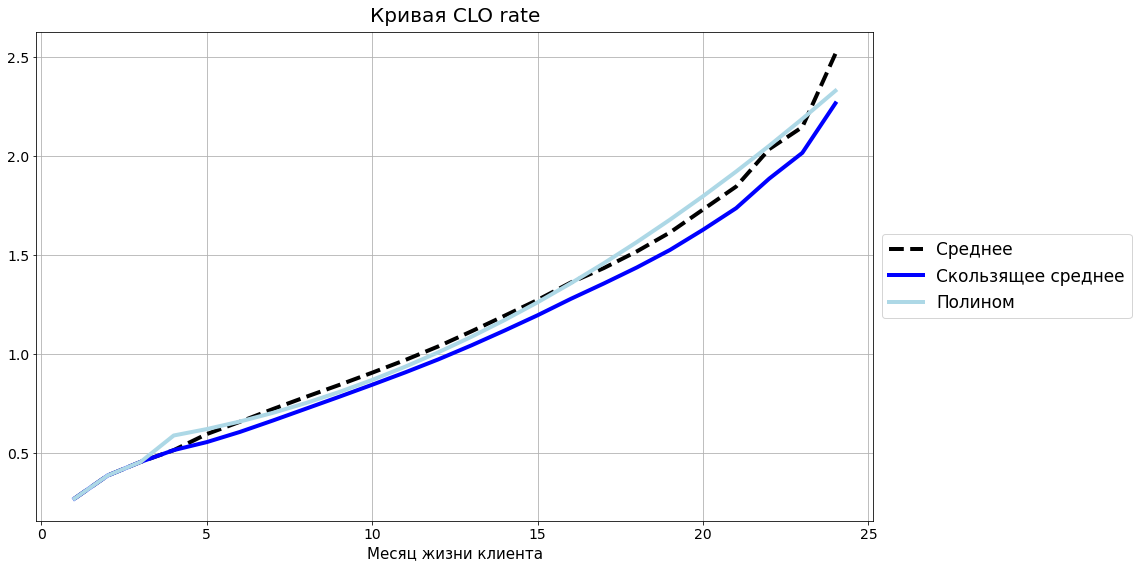

In [27]:
for i in range(3):
    df_bucket = clo_rate_mean.query(f'x_bucket == {i}').reset_index().set_index(['statement_num'])
    df_polynom = polynom_approximation(df_bucket, 4,24,2)
    df_smooth = exponential_smoothing(df_bucket, 4,24,0.5)
    # Строим получившиеся графики вместе
    plt.figure(figsize=(15, 9))
    df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
    df_smooth['Скользящее среднее'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
    df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

Сглаженные модельные кривые

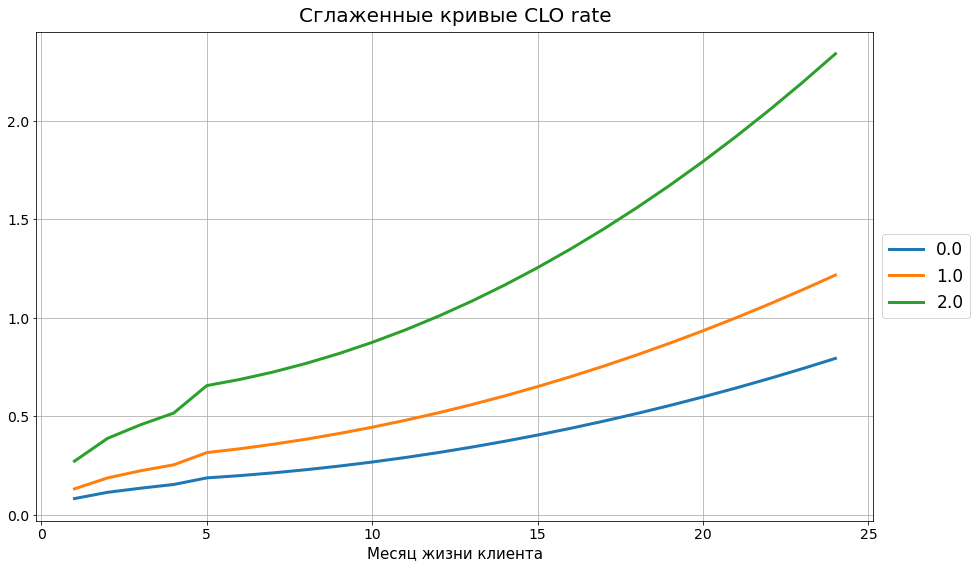

In [28]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат
buckets = df['x_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Делаем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые CLO rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)